In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Setting it to -1 disables GPU


import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"  # Example MobileNetV2 from TF Hub
classifier = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape=IMAGE_SHAPE+(3,))
])

# Load dataset:

In [3]:
data_dir='..\\Emotion Recognition\\images\\train'

In [4]:
data_dir

'..\\Emotion Recognition\\images\\train'

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('../Emotion Recognition/images/train')

In [6]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('../Emotion Recognition/images/train/angry/0.jpg'),
 WindowsPath('../Emotion Recognition/images/train/angry/1.jpg'),
 WindowsPath('../Emotion Recognition/images/train/angry/10.jpg'),
 WindowsPath('../Emotion Recognition/images/train/angry/10002.jpg'),
 WindowsPath('../Emotion Recognition/images/train/angry/10016.jpg')]

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

28821


# Read Emotion images from disk into numpy array using opencv:

In [8]:
emotion_images_dict = {
    'angry': list(data_dir.glob('angry/*')),
    'disgust': list(data_dir.glob('disgust/*')),
    'fear': list(data_dir.glob('fear/*')),
    'happy': list(data_dir.glob('happy/*')),
    'neutral': list(data_dir.glob('neutral/*')),
    'sad': list(data_dir.glob('sad/*')),
    'surprise': list(data_dir.glob('surprise/*'))
}

In [9]:
emotion_labels_dict = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad' : 5,
    'surprise' :6
}

In [10]:
emotion_images_dict['sad'][:5]

[WindowsPath('../Emotion Recognition/images/train/sad/10006.jpg'),
 WindowsPath('../Emotion Recognition/images/train/sad/10008.jpg'),
 WindowsPath('../Emotion Recognition/images/train/sad/1001.jpg'),
 WindowsPath('../Emotion Recognition/images/train/sad/10020.jpg'),
 WindowsPath('../Emotion Recognition/images/train/sad/10028.jpg')]

In [11]:
str(emotion_images_dict['sad'][0])

'..\\Emotion Recognition\\images\\train\\sad\\10006.jpg'

In [12]:
img=cv2.imread(str(emotion_images_dict['sad'][0]))

In [13]:
img.shape

(48, 48, 3)

In [14]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

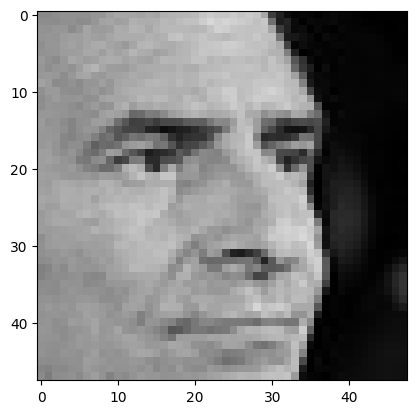

In [15]:
plt.imshow(img)

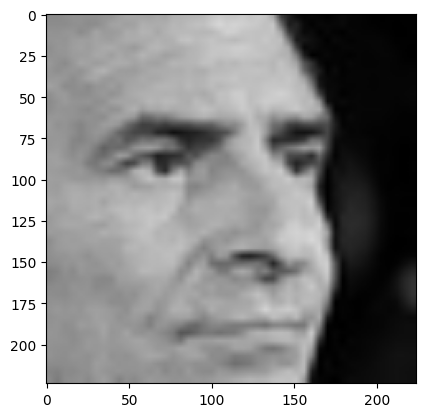

In [16]:
plt.imshow(cv2.resize(img,(224,224)))

In [17]:
X, y = [], []

for emotion_name, images in emotion_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(emotion_labels_dict[emotion_name])

In [18]:
X = np.array(X)
y = np.array(y)

In [19]:
unique_elements, counts = np.unique(y, return_counts=True)

# Afficher les résultats
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} occurrence(s)")

0: 3993 occurrence(s)
1: 436 occurrence(s)
2: 4103 occurrence(s)
3: 7164 occurrence(s)
4: 4982 occurrence(s)
5: 4938 occurrence(s)
6: 3205 occurrence(s)


In [20]:
X = X.astype('float32')

In [21]:
X_scaled = X / 255.0

In [22]:
X.shape

(28821, 224, 224, 3)

In [23]:
feature_extractor_model="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [27]:
num_of_emotions= 7

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_emotions)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_scaled, y, epochs=10)

Epoch 1/10
901/901 [==============================] - 469s 517ms/step - loss: 1.5251 - acc: 0.4191
Epoch 2/10
901/901 [==============================] - 491s 545ms/step - loss: 1.3620 - acc: 0.4886
Epoch 3/10
901/901 [==============================] - 476s 528ms/step - loss: 1.3105 - acc: 0.5085
Epoch 4/10
901/901 [==============================] - 467s 518ms/step - loss: 1.2790 - acc: 0.5213
Epoch 5/10
901/901 [==============================] - 471s 523ms/step - loss: 1.2611 - acc: 0.5301
Epoch 6/10
901/901 [==============================] - 466s 517ms/step - loss: 1.2425 - acc: 0.5349
Epoch 7/10
901/901 [==============================] - 471s 523ms/step - loss: 1.2305 - acc: 0.5415
Epoch 8/10
901/901 [==============================] - 481s 534ms/step - loss: 1.2215 - acc: 0.5425
Epoch 9/10
901/901 [==============================] - 474s 526ms/step - loss: 1.2120 - acc: 0.5486
Epoch 10/10
901/901 [==============================] - 482s 535ms/step - loss: 1.2066 - acc: 0.5505


# save the model:

In [29]:
model.save('../Emotion Recognition/model2.h5')